# Session 20 - Dtable Diffusion Deep dive

In [ ]:
#Installations
!pip install -q --upgrade transformers==4.25.1 diffusers ftfy accelerate
#!pip install ipywidgets

##### Hugging face sign in

In [2]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel, StableDiffusionPipeline
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os

torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### Loading the Stable diffuion pipeline

In [3]:
model_nm = "CompVis/stable-diffusion-v1-4"

output_dir="sd-concept-output"
pipe = StableDiffusionPipeline.from_pretrained(model_nm).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

#### Fetching the AE, UNET, CLIP models from Stable diffusion pipleine

In [5]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = pipe.vae
tokenizer = pipe.tokenizer

# Load the tokenizer and text encoder to tokenize and encode the text.
#tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder =pipe.text_encoder

# The UNet model for generating the latents.
unet = pipe.unet

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

#### Deepdive into the Stable Diffusion pipeline

/tmp/ipykernel_115/4195205535.py:31: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

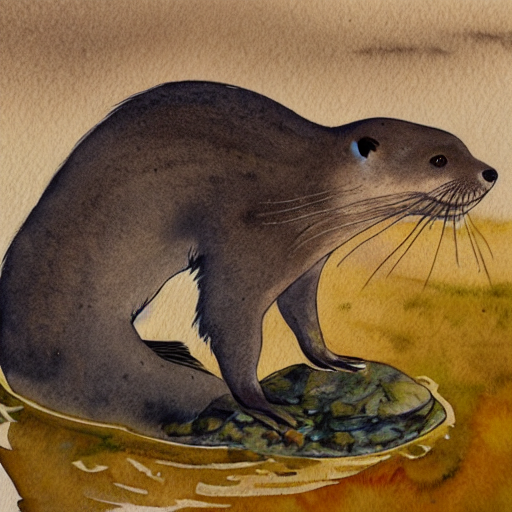

In [6]:
# Some settings
prompt = ["A watercolor painting of an otter"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 30            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

# Prep text
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32) # minor fix to ensure MPS compatibility, fixed in diffusers PR 3925

set_timesteps(scheduler,num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]

# Loop
with autocast("cuda"):  # will fallback to CPU if no CUDA; no autocast for MPS
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        # Scale the latents (preconditioning):
        # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        # latents = scheduler.step(noise_pred, i, latents)["prev_sample"] # Diffusers 0.3 and below
        latents = scheduler.step(noise_pred, t, latents).prev_sample

# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

### Assignment Part - 1 - Get different styles with textual inversions

##### Style-1

  0%|          | 0/100 [00:00<?, ?it/s]

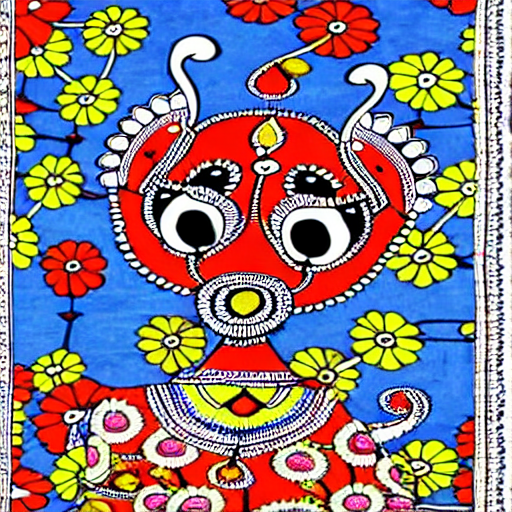

In [7]:
pipe.load_textual_inversion("sd-concepts-library/madhubani-art")
prompt = "a puppy in <madhubani-art> style"
images = pipe([prompt] * 2, num_inference_steps=100, guidance_scale=15).images
madhubani_puppy = images[0]
madhubani_puppy

##### Style-2

  0%|          | 0/100 [00:00<?, ?it/s]

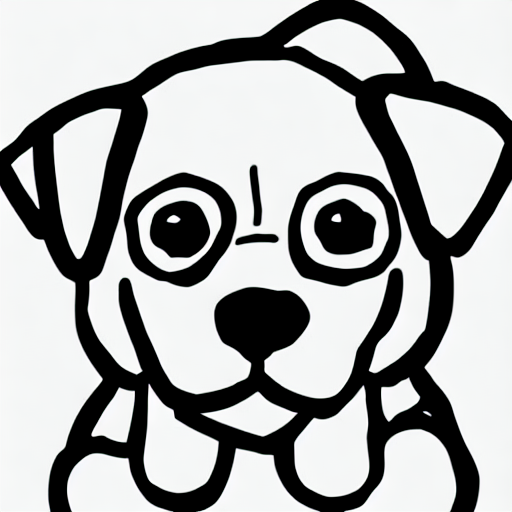

In [8]:
prompt = "a puppy in <line-art> style"
images = pipe([prompt] * 2, num_inference_steps=100, guidance_scale=15).images
images[0]
simple_puppy = images[0]
simple_puppy

##### Style-3

  0%|          | 0/100 [00:00<?, ?it/s]

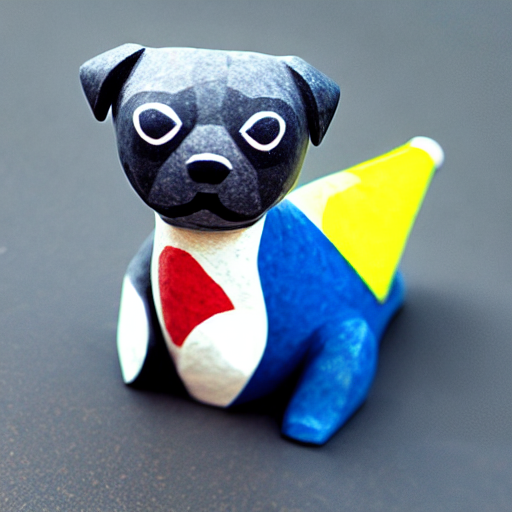

In [9]:
pipe.load_textual_inversion("sd-concepts-library/cat-toy")
prompt = "a puppy in <cat-toy> style"
images = pipe([prompt] * 2, num_inference_steps=100, guidance_scale=15).images
pokemon_puppy = images[0]
pokemon_puppy

##### Style-4

  0%|          | 0/100 [00:00<?, ?it/s]

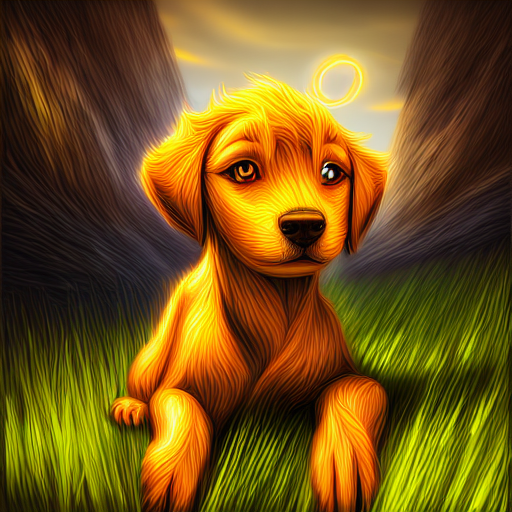

In [10]:
pipe.load_textual_inversion("sd-concepts-library/concept-art") 
prompt = "a puppy in <concept-art>"
images = pipe([prompt] * 2, num_inference_steps=100, guidance_scale=15).images
concept_art_puppy = images[0]
concept_art_puppy

#### Some utility functions

In [11]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [12]:
# Prep Scheduler
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32) # minor fix to ensure MPS compatibility, fixed in diffusers

### Assignment Part 2 - Custom Loss

In [13]:
import cv2

In [16]:

def saturation_loss(image): 
    print(type(image))
    #Convert to hue, saturation, 
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)    
    # Extract saturation channel
    saturation_channel = hsv_image[:, :, 1]
    
    # Calculate mean saturation value
    mean_saturation = np.mean(saturation_channel)
    # How far are the blue channel values to 0.9:
    #error = torch.abs(images[:,2] - 0.9).mean() # [:,2] -> all images in batch, only the blue channel
    return mean_saturation

In [17]:
prompt = 'a puppy in <concept-art>' #@param
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 30  #@param           # Number of denoising steps
guidance_scale = 8 #@param               # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1
blue_loss_scale = 200 #@param

# Prep text
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
set_timesteps(scheduler, num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    #print(f"Length of sigmas = {len(scheduler.sigmas)}")
    #print(f"t = {t}")
    #print(f"noise_pred = {noise_pred}")
    #print(f"latents = {latents}")
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform CFG
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    #### ADDITIONAL GUIDANCE ###
    if i%5 == 0:
        # Requires grad on the latents
        latents = latents.detach().requires_grad_()

        # Get the predicted x0:
        #latents_x0 = latents - sigma * noise_pred
        latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

        # Decode to image space
        denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

        # Calculate loss
        loss = saturation_loss(denoised_images) * blue_loss_scale

        # Occasionally print it out
        if i%10==0:
            print(i, 'loss:', loss.item())

        # Get gradient
        cond_grad = torch.autograd.grad(loss, latents)[0]

        # Modify the latents based on this gradient
        latents = latents.detach() - cond_grad * sigma**2
        scheduler._step_index = scheduler._step_index - 1

    # Now step with scheduler
    latents = scheduler.step(noise_pred, t, latents).prev_sample


latents_to_pil(latents)[0]

/tmp/ipykernel_115/3094012077.py:29: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 15.90 GiB total capacity; 14.51 GiB already allocated; 45.75 MiB free; 14.78 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

#### With custom loss

In [ ]:
latents_to_pil(latents)[0]

In [ ]:
from torchvision import models, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Load a pre-trained ResNet-50 model
resnet_model = models.resnet50(pretrained=True)
resnet_model = torch.nn.Sequential(*(list(resnet_model.children())[:-2]))  # Remove the last two layers

# Set the model in evaluation mode
resnet_model.eval()

# Set up a transform to preprocess images for ResNet model
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define a custom loss function using perceptual loss with ResNet-50 features
def custom_loss(predictions, targets):

       # Get feature representations from ResNet model
    features_pred = resnet_model(predictions.unsqueeze(0))
    features_target = resnet_model(targets.unsqueeze(0))

    # Compute mean squared error loss on ResNet features
    perceptual_loss = F.mse_loss(features_pred, features_target)
    
    # You can add additional custom components to the loss if needed
    
    # Return the total loss
    return perceptual_loss

# Dummy data for demonstration (replace with your actual data)
inputs = simple_dog  # Example input tensor (batch_size, channels, height, width)
targets = avengers  # Example target tensor (batch_size, channels, height, width)

# Preprocess predictions and targets for ResNet model
predictions_tensor = transform(inputs)
targets_tensor = transform(targets)

# Set predictions tensor to require gradient for optimization
predictions_tensor.requires_grad = True

# Adam optimizer for optimizing predictions
optimizer = torch.optim.Adam([predictions_tensor], lr=0.01)

# Number of optimization steps
num_steps = 100

# Lists to store predictions for plotting
prediction_images = []

# Optimization loop
for step in range(num_steps):
    # Forward pass: compute loss and backpropagation
    loss = custom_loss(predictions_tensor, targets_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Save predictions for plotting
    prediction_images.append(predictions_tensor.clone().detach())  # Clone to detach from the computation graph

    # Print loss every few steps
    if (step + 1) % 10 == 0:
        print(f"Step [{step + 1}/{num_steps}], Loss: {loss.item():.4f}")

# Plot the predictions
plt.figure(figsize=(12, 6))
for i in range(len(prediction_images)):
    plt.subplot(2, 5, i + 1)
    prediction = prediction_images[i].squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    plt.imshow(prediction)
    plt.axis('off')
    plt.title(f'Step {i * 100}')

plt.tight_layout()
plt.show()

# Print final loss
print("Final Loss:", loss.item())